# Description

In the previous notebook, we found that LV603 gene weight's are predictive of gene associations for basophil percentage.
In a real application, you would run the `gls_cli.py` tool for your trait of interest across all LVs in our models, and get the significant ones. Then you can see in which cell types the LVs' genes are expressed, and this is what we are going to do in this notebook for LV603.

To find the cell types associated with an LV, we'll use matrix **B** (see the figure b) below and our [manuscript](https://greenelab.github.io/phenoplier_manuscript/#phenoplier-an-integration-framework-based-on-gene-co-expression-patterns)).
We can link RNA-seq samples in matrix B with gene expression metadata and explore which cell types are associated with the LV.
However, metadata in gene expression datasets is usually hard to read, process and interpret, and many times important attributes (such as `tissue` or `cell type`) are missing.
We provide some tools to try to overcome this problem, and it is shown below.

![](https://greenelab.github.io/phenoplier_manuscript/images/entire_process/entire_process.svg)

# Modules

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs"))
os.environ["PHENOPLIER_ROOT_DIR"] = "/pl/active/pivlab/projects/srajery/data/phenoplier"

import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

Specify below the LV id you are interested in:

In [2]:
LV_NAME = "LV913"

# Paths

These are paths to folder and files where we'll save our figures.

In [3]:
OUTPUT_FIGURES_DIR = Path(conf.RESULTS_DIR, "demo", f"{LV_NAME.lower()}").resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/pl/active/pivlab/projects/srajery/data/phenoplier/results/demo/lv913')

In [4]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/pl/active/pivlab/projects/srajery/data/phenoplier/results/demo/lv913/lv913-cell_types.svg')

# Load MultiPLIER summary

In [5]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [6]:
multiplier_model_summary.shape

(2157, 5)

In [7]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load LV data

You can use the `LVAnalysis` class to explore an LV.

In [8]:
lv_obj = LVAnalysis(LV_NAME)

Here I show the top 20 genes for our LV. You can see gene symbols, the LV weight (in column `LV603`) and the cytoband.

In [9]:
lv_obj.lv_genes.head(20)

,gene_name,LV913,gene_band
0,PLA2G2D,5.509843,1p36.12
1,IGKC,4.995934,NaN
2,CCL19,3.842465,9p13.3
3,DERL3,3.381121,22q11.23
4,NOS2,3.315122,17q11.2
5,CXCL13,3.243843,4q21.1
6,OLFM4,2.765351,13q14.3
7,C1QB,2.169730,1p36.12
8,MZB1,2.124240,5q31.2
9,IGHM,2.093565,NaN


Show the pathways our LV is aligned to (neutrophils):

In [10]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        & (multiplier_model_summary["AUC"] >= 0.75)
    )
]

,pathway,LV index,AUC,p-value,FDR


Here I load the LV metadata.
This is, for each sample from our matrix B, we load its metadata.
The `LVAnalysis` class takes care of downloading all necessary files from recount2.

In [11]:
lv_data = lv_obj.get_experiments_data()

SRP039591, SRP048801, SRP042228, SRP009251, SRP063496, SRP006575, SRP029452, SRP041377, SRP042161, SRP052615, SRP019994, SRP007359, SRP041826, SRP052740, SRP023262, SRP050499, SRP063838, SRP056733, SRP007338, SRP057196, SRP039361, 

In [12]:
lv_data.shape

(3133, 51)

In [13]:
lv_data.head()

diagnosis  \
project   run                                                
SRP039591 SRR1186052  Hepatosplenic T-cell lymphoma (HSTL)   
          SRR1186053  Hepatosplenic T-cell lymphoma (HSTL)   
          SRR1186055  Hepatosplenic T-cell lymphoma (HSTL)   
          SRR1186054  Hepatosplenic T-cell lymphoma (HSTL)   
          SRR1186056                         normal tissue   

                                                              karyotype  \
project   run                                                             
SRP039591 SRR1186052  45-46,X,-Y,-4,der(7)add(7)(p22)add(7)(q32), i(...   
          SRR1186053  46-47,XY,add(4)(p16),i(7)(q10),+8[4],-[20],+ma...   
          SRR1186055   46,XY,add(5)(q?),i(7)(q10),-10[5][cp15]c .aCGH+8   
          SRR1186054  40-48,XY,+X  [3],-5[4],i(7)(q10),+8[5],+10[2],...   
          SRR1186056                                                 NA   

                       tissue age at diagnosis gender paris age at diagnosis  \
project   run                                                                  
SRP039591 SRR1186052   Spleen              NaN    NaN                    NaN   
          SRR1186053   Spleen              NaN    NaN                    NaN   
          SRR1186055  culture              NaN    NaN                    NaN   
          SRR1186054   Spleen              NaN    NaN                    NaN   
          SRR1186056   Spleen              NaN    NaN                    NaN   

                     sample type  Sex paris age l2 type  ... individual  \
project   run                                            ...              
SRP039591 SRR1186052         NaN  NaN       NaN     NaN  ...        NaN   
          SRR1186053         NaN  NaN       NaN     NaN  ...        NaN   
          SRR1186055         NaN  NaN       NaN     NaN  ...        NaN   
          SRR1186054         NaN  NaN       NaN     NaN  ...        NaN   
          SRR1186056         NaN  NaN       NaN     NaN  ...        NaN   

                     time point batch  rin illumina_index library type  \
project   run                                                            
SRP039591 SRR1186052        NaN   NaN  NaN            NaN          NaN   
          SRR1186053        NaN   NaN  NaN            NaN          NaN   
          SRR1186055        NaN   NaN  NaN            NaN          NaN   
          SRR1186054        NaN   NaN  NaN            NaN          NaN   
          SRR1186056        NaN   NaN  NaN            NaN          NaN   

                     read length c1 chip id experiment_sample_name     LV913  
project   run                                                                 
SRP039591 SRR1186052         NaN        NaN                    NaN  0.134289  
          SRR1186053         NaN        NaN                    NaN  0.198414  
          SRR1186055         NaN        NaN                    NaN -0.039745  
          SRR1186054         NaN        NaN                    NaN  0.063212  
          SRR1186056         NaN        NaN                    NaN  0.423830  

[5 rows x 51 columns]

# LV cell types analysis

## Get top attributes

Here I quickly show the top attributes in our metadata for which we have the largest LV variance.
This is just to have an idea of the variance across different attributes

In [14]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs/data/recount2.py:374: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  _tmp = getattr(_tmp, func)()
/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs/data/recount2.py:374: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  _tmp = getattr(_tmp, func)()
/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs/data/recount2.py:374: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. I

karyotype                  0.079212
tissue                     0.047199
gender                     0.046444
foxp1 expression by ihc    0.044323
foxp rearrangement         0.044323
medication                 0.041825
disease state              0.040416
diagnosis                  0.040351
paris age                  0.040327
Sex                        0.040327
histopathology             0.040327
deep ulcer                 0.040327
l2 type                    0.040327
age at diagnosis           0.039260
sample type                0.039056
paris age at diagnosis     0.038329
tissue diagnosis           0.028373
prior anti.tnf             0.028373
inventory sample name      0.028373
remission at week 10       0.028373
dtype: float64

Since we are interested in cell types and tissues, the code below will find which attributes contain "cell type" or "tissue", so we can select from these results.

In [15]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.*(type|line)$)|(?:tissue$)|(?:tissue.*type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue       0.047199
cell type    0.002934
cell line    0.002358
dtype: float64

Select from the output above those you are interested in. Usually all of them.

In [18]:
lv_attrs_selected = [
    "cell type",
    "cell line",
    "tissue",
]

In [19]:
_tmp = lv_data.loc[
    :,
    lv_attrs_selected + [LV_NAME],
]

In [20]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

Now that we selected attributes that might be providing information about the cell type, we can see which are the top ones.

If you change the number in the cell below, you can paginate over the entire set of results; for example, with `_tmp_seq[1]` you'll see the next "page" in a descending order with respect to the LV value. So the ones at the top are the most important ones.

In [21]:
_tmp_seq[0]

cell type cell line               tissue     LV913
project   run                                                          
SRP039591 SRR1186058       NaN       NaN           Lymph node  1.049186
SRP048801 SRR1609451       NaN       NaN                ileum  0.885230
          SRR1609571       NaN       NaN                ileum  0.830938
SRP042228 SRR1782705       NaN       NaN         Ileal biopsy  0.830748
SRP048801 SRR1609427       NaN       NaN                ileum  0.817182
SRP042228 SRR1782871       NaN       NaN         Ileal biopsy  0.817103
          SRR1782974       NaN       NaN         Ileal biopsy  0.792195
SRP048801 SRR1609556       NaN       NaN                ileum  0.749497
SRP009251 SRR363759        NaN       NaN                 skin  0.731316
SRP042228 SRR1782701       NaN       NaN         Ileal biopsy  0.725472
SRP048801 SRR1609507       NaN       NaN                ileum  0.725272
SRP042228 SRR1782878       NaN       NaN         Ileal biopsy  0.717746
SRP048801 SRR1609626       NaN       NaN                ileum  0.716992
          SRR1609439       NaN       NaN                ileum  0.705692
SRP042228 SRR1782841       NaN       NaN         Ileal biopsy  0.705475
SRP048801 SRR1609579       NaN       NaN                ileum  0.703638
SRP042228 SRR1782794       NaN       NaN         Ileal biopsy  0.703537
SRP048801 SRR1609521       NaN       NaN                ileum  0.701984
SRP042228 SRR1782691       NaN       NaN         Ileal biopsy  0.701711
SRP063496 SRR2314025       NaN       NaN       colonic biopsy  0.698969
SRP042228 SRR1782845       NaN       NaN         Ileal biopsy  0.691956
SRP048801 SRR1609623       NaN       NaN                ileum  0.691686
SRP006575 SRR191645        NaN       NaN  lung adenocarcinoma  0.683891
SRP042228 SRR1782872       NaN       NaN         Ileal biopsy  0.681505
SRP048801 SRR1609416       NaN       NaN                ileum  0.681440

You can see above that the RNA-seq samples are from neutrophils or granulocytes.
If we move to the next "page", we'll see this:

In [22]:
_tmp_seq[1]

cell type                  cell line  \
project   run                                                   
SRP048801 SRR1609649           NaN                        NaN   
SRP042228 SRR1782995           NaN                        NaN   
SRP006575 SRR191646            NaN                        NaN   
SRP063496 SRR2313982           NaN                        NaN   
SRP029452 SRR962600            NaN                        NaN   
SRP048801 SRR1609544           NaN                        NaN   
SRP042228 SRR1782791           NaN                        NaN   
          SRR1782884           NaN                        NaN   
SRP009251 SRR363764            NaN                        NaN   
SRP048801 SRR1609635           NaN                        NaN   
          SRR1609430           NaN                        NaN   
SRP042228 SRR1782786           NaN                        NaN   
          SRR1782865           NaN                        NaN   
SRP048801 SRR1609600           NaN                        NaN   
SRP042228 SRR1782826           NaN                        NaN   
SRP048801 SRR1609417           NaN                        NaN   
          SRR1609532           NaN                        NaN   
          SRR1609572           NaN                        NaN   
SRP042228 SRR1782807           NaN                        NaN   
SRP048801 SRR1609483           NaN                        NaN   
SRP041377 SRR1258912           NaN  WIBR3 with fused GFP+LGR5   
SRP042228 SRR1782823           NaN                        NaN   
SRP048801 SRR1609482           NaN                        NaN   
SRP042161 SRR1294546  Glioblastoma                        NaN   
SRP009251 SRR363756            NaN                        NaN   

                                   tissue     LV913  
project   run                                        
SRP048801 SRR1609649                ileum  0.679055  
SRP042228 SRR1782995         Ileal biopsy  0.678787  
SRP006575 SRR191646   lung adenocarcinoma  0.671689  
SRP063496 SRR2313982       colonic biopsy  0.671637  
SRP029452 SRR962600              lymphoma  0.667860  
SRP048801 SRR1609544                ileum  0.653797  
SRP042228 SRR1782791         Ileal biopsy  0.653529  
          SRR1782884         Ileal biopsy  0.635504  
SRP009251 SRR363764                  skin  0.635153  
SRP048801 SRR1609635                ileum  0.634051  
          SRR1609430                ileum  0.633902  
SRP042228 SRR1782786         Ileal biopsy  0.633885  
          SRR1782865         Ileal biopsy  0.633689  
SRP048801 SRR1609600                ileum  0.630720  
SRP042228 SRR1782826         Ileal biopsy  0.623003  
SRP048801 SRR1609417                ileum  0.622833  
          SRR1609532                ileum  0.620936  
          SRR1609572                ileum  0.618675  
SRP042228 SRR1782807         Ileal biopsy  0.612560  
SRP048801 SRR1609483                ileum  0.611988  
SRP041377 SRR1258912                  NaN  0.607589  
SRP042228 SRR1782823         Ileal biopsy  0.605695  
SRP048801 SRR1609482                ileum  0.605504  
SRP042161 SRR1294546                  NaN  0.604031  
SRP009251 SRR363756                  skin  0.603527

Although the attributes we selected (`cell type`, `celltype` and `tissue`) seem to be enough for most of the RNA-seq samples to get their cell types, this is not the case for some of them. For example, we have empty values (NaN) for `SRP015360`.

You can explore the metadata provided for a particular SPR with the code below. Let's see what we have in `SRP015360`:

In [24]:
# list the top 10 samples from this project
lv_data.loc[["SRP048801"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(10)

diagnosis tissue age at diagnosis  gender  \
project   run                                                    
SRP048801 SRR1609451       iCD  ileum              9.5  Female   
          SRR1609571       iCD  ileum        10.333333    Male   
          SRR1609427       iCD  ileum                8    Male   
          SRR1609556       iCD  ileum             16.5  Female   
          SRR1609507       iCD  ileum            13.25    Male   
          SRR1609626       cCD  ileum              9.5  Female   
          SRR1609439       iCD  ileum         8.833333  Female   
          SRR1609579       iCD  ileum        11.333333    Male   
          SRR1609521       iCD  ileum        14.333333    Male   
          SRR1609623       cCD  ileum      8.833333333  Female   

                     paris age at diagnosis   sample type     LV913  
project   run                                                        
SRP048801 SRR1609451                    A1a  Ileal biopsy  0.885230  
          SRR1609571                    A1b  Ileal biopsy  0.830938  
          SRR1609427                    A1a  Ileal biopsy  0.817182  
          SRR1609556                    A1b  Ileal biopsy  0.749497  
          SRR1609507                    A1b  Ileal biopsy  0.725272  
          SRR1609626                    A1a  Ileal biopsy  0.716992  
          SRR1609439                    A1a  Ileal biopsy  0.705692  
          SRR1609579                    A1b  Ileal biopsy  0.703638  
          SRR1609521                    A1b  Ileal biopsy  0.701984  
          SRR1609623                    A1a  Ileal biopsy  0.691686

So for `SRP015360` we only have three attributes: `age`, `Sex` and `treatment`. No cell type information. Here you can start grasping the challenges in analyzing this data.

If you are really interested in this metadata for this project, you can use this URL:
```
https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360
```
where you can put the SRP code you want. If you check the URL above, you'll see that these samples were taken from neutrophils as well (treated with different stimuli), although we don't have metadata about the cell type/tissue.

Ok, we do not want several attributes conveying the same information (cell types), just a single one, so here we'll combine the attributes we found before with a particular _order_.
In this case I select `cell type` _first_ (the order is important), `celltype` as second, and `tissue` as third/last.
This means that I will use the information in `cell type` first, but if this is empty (as in `SRP045500`), we'll try with `celltype`, and so on.

In [25]:
SELECTED_ATTRIBUTES = [
    "cell type",
    "cell line",
    "tissue",
]

## Get a single attribute with "cell type/tissue" information

In [26]:
plot_data = lv_data.loc[:, SELECTED_ATTRIBUTES + [LV_NAME]]

In [27]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[SELECTED_ATTRIBUTES].fillna(method="backfill", axis=1)[
    SELECTED_ATTRIBUTES[0]
]
plot_data[SELECTED_ATTRIBUTES[0]] = _new_column
plot_data = plot_data.drop(columns=SELECTED_ATTRIBUTES[1:])
plot_data = plot_data.fillna({SELECTED_ATTRIBUTES[0]: "NOT CATEGORIZED"})

In [28]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [29]:
plot_data.head(20)

cell type     LV913
project   run                                 
SRP039591 SRR1186058      Lymph node  1.049186
SRP048801 SRR1609451           ileum  0.885230
          SRR1609571           ileum  0.830938
SRP042228 SRR1782705    Ileal biopsy  0.830748
SRP048801 SRR1609427           ileum  0.817182
SRP042228 SRR1782871    Ileal biopsy  0.817103
          SRR1782974    Ileal biopsy  0.792195
SRP048801 SRR1609556           ileum  0.749497
SRP009251 SRR363759             skin  0.731316
SRP042228 SRR1782701    Ileal biopsy  0.725472
SRP048801 SRR1609507           ileum  0.725272
SRP042228 SRR1782878    Ileal biopsy  0.717746
SRP048801 SRR1609626           ileum  0.716992
          SRR1609439           ileum  0.705692
SRP042228 SRR1782841    Ileal biopsy  0.705475
SRP048801 SRR1609579           ileum  0.703638
SRP042228 SRR1782794    Ileal biopsy  0.703537
SRP048801 SRR1609521           ileum  0.701984
SRP042228 SRR1782691    Ileal biopsy  0.701711
SRP063496 SRR2314025  colonic biopsy  0.698969

You can see that now all attributes ("celltype", "cell type" and "tissue") are combined under a single attribute named "cell type".
For example, if you look at `SRP045500`, which had a value under "celltype" but an empty (NaN) value for attribute "cell type", that now the value was moved to "cell type" (it was unified into this single attribute).

If you see "NOT CATEGORIZED", it means that none of the attributes you used had a value (they were all empty or NaN). In this case you would go the URL before and read the article/RNA-seq data description to find out the cell type or tissue (or whatever attribute your are interested in).

## Standardize cell type names

When cell type values are different but represent the same cell type, we unify them:

In [30]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTES[0]: {
            # neutrophils:
            "primary human neutrophils": "Neutrophils",
            "Neutrophil isolated from peripheral blood": "Neutrophils",
            "Neutrophil": "Neutrophils",
            "neutrophils (Neu)": "Neutrophils",
            # granulocytes:
            "granulocyte": "Granulocytes",
            # monocytes:
            "primary human monocytes": "Monocytes",
            # whole blood:
            #             "whole blood": "Whole blood",  # uncomment this line to merge occurences of "whole blood" into "Whole blood"
            "Whole Blood": "Whole blood",
            # PBMC:
            "primary human PBMC": "PBMC",
            # B-cells:
            "primary human B cells": "B cells",
            # T-cells:
            "primary human T cells": "T cells",
            # epithelial cells:
            "epithelial cells (Epi)": "Epithelial cells",
            "primary human myeloid DC": "mDCs",
        }
    }
)

The code below is more advanced, but you can use it to customize even further your final attribute value (for example, if you want to use the cell type, but put the treatment name with parenthesis).

In [28]:
# # add also tissue information to these projects
# _srp_code = "SRP061881"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: lv_data.loc[(_srp_code, x.name), "cell type"]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTES[0]] = _tmp.values

In [29]:
# # all samples from SRP015360 are neutrophils
# final_plot_data[SELECTED_ATTRIBUTES[0]] = final_plot_data.apply(
#     lambda x: "Neutrophils" if x.name[0] in ("SRP015360",) else x[SELECTED_ATTRIBUTES[0]],
#     axis=1,
# )

In [31]:
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)

## Threshold LV values

The code below is useful in case you want to put a threshold to the plot (for example, you have same samples with very high values).

In [31]:
# final_plot_data.loc[
#     final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
# ] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

If you are not interested in samples for which we couldn't find cell type/tissue information, you can delete them by uncommenting the code below.
However, if you want, you can take a look at those later (we'll show you how at the end).

In [32]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set top cell types to show

In [32]:
N_TOP_ATTRS = 10

In [33]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTES[0])
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [34]:
len(attr_order)

10

In [35]:
attr_order[:5]

['Lymph node', 'ileum', 'Ileal biopsy', 'skin', 'colonic biopsy']

# Plot

Now we create the plot with RNA-seq samples as points, cell types in the x-axis, and the LV value in the y-axis.
This shows you in which cell types genes in LV603 are primirily expressed.

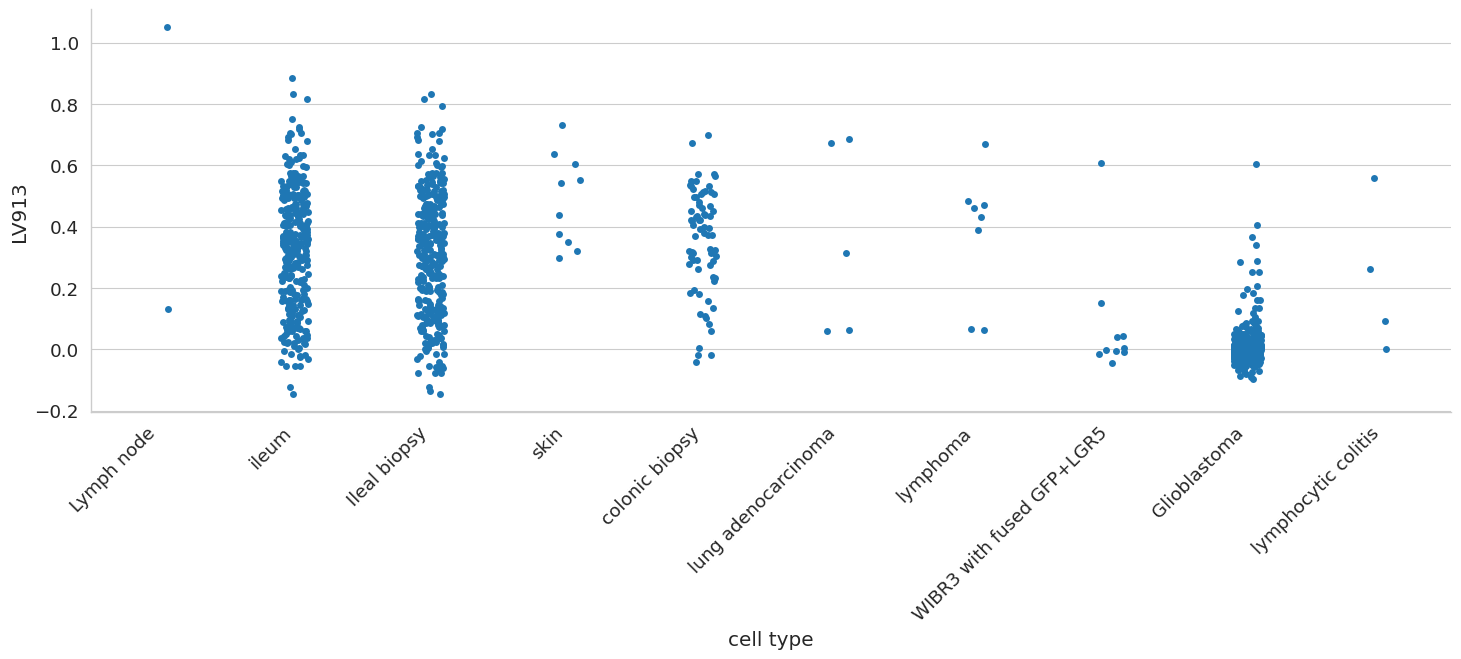

In [36]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTES[0],
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    # You can save the figure if you uncomment the code below
    # the figure will be created under ${DATA_FOLDER}/results/demo

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

Now that you have the figure for your LV, you can debug some things.
For example, you'll see above that some samples are "NOT CATEGORIZED".
Let's see which are those:

In [38]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[
        final_plot_data[SELECTED_ATTRIBUTES[0]].str.contains("NOT CAT")
    ]
    display(_tmp.head(20))

cell type     LV603
project   run                                  
SRP015360 SRR553460   NOT CATEGORIZED  1.936240
          SRR553463   NOT CATEGORIZED  1.614990
          SRR553461   NOT CATEGORIZED  1.538253
SRP051848 SRR1747386  NOT CATEGORIZED  1.512612
SRP015360 SRR553464   NOT CATEGORIZED  1.368832
SRP051848 SRR1747242  NOT CATEGORIZED  1.313651
          SRR1747230  NOT CATEGORIZED  1.283074
SRP017138 SRR616078   NOT CATEGORIZED  1.267509
SRP051848 SRR1747372  NOT CATEGORIZED  1.266037
          SRR1747348  NOT CATEGORIZED  1.257565
          SRR1747322  NOT CATEGORIZED  1.253071
          SRR1747312  NOT CATEGORIZED  1.247533
          SRR1747314  NOT CATEGORIZED  1.241307
          SRR1747248  NOT CATEGORIZED  1.211017
          SRR1747264  NOT CATEGORIZED  1.169013
          SRR1747304  NOT CATEGORIZED  1.164252
          SRR1747275  NOT CATEGORIZED  1.160602
          SRR1747247  NOT CATEGORIZED  1.129323
          SRR1747321  NOT CATEGORIZED  1.116180
          SRR1747232  NOT CATEGORIZED  1.098986

We don't have information about cell type/tissue for these.
But we can manually go to the URL showed before and check out.
For example, for `SRP015360` we can open our browser with this URL:
https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360, and see that the samples were taken from neutrophils.

If you need to see which information is provided by each SRP, you can again use the code below:

In [39]:
# what is there in these projects?
lv_data.loc[["SRP015360"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(60)

age   Sex                                   treatment  \
project   run                                                               
SRP015360 SRR553460  30  male                                        none   
          SRR553463  58  male                                        none   
          SRR553461  30  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553464  58  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553462  30  male      incubated for 1h with GM-CSF (5 ng/mL)   
          SRR553465  58  male      incubated for 1h with GM-CSF (5 ng/mL)   

                        LV603  
project   run                  
SRP015360 SRR553460  1.936240  
          SRR553463  1.614990  
          SRR553461  1.538253  
          SRR553464  1.368832  
          SRR553462  1.016750  
          SRR553465  0.798007

Now you can go back to section `Standardize cell type names` in this notebook and adjust according to this findings to improve the figure.
Once you are happy, you can remove the `NOT CATEGORIZED` items by uncommenting the code in `Delete samples with no tissue/cell type information`.